In [1]:
!pip install -q transformers scikit-learn pandas numpy kagglehub tqdm


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sunilthite/llm-detect-ai-generated-text-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/llm-detect-ai-generated-text-dataset


AI vs Human Text Detection Model
Error loading dataset: CSV must contain 'text' and 'label' columns
Failed to load CSV. Using sample dataset instead.
Preprocessing texts...
Extracting features...
Training model...

Model Performance:
Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

       Human       0.67      1.00      0.80         2
          AI       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



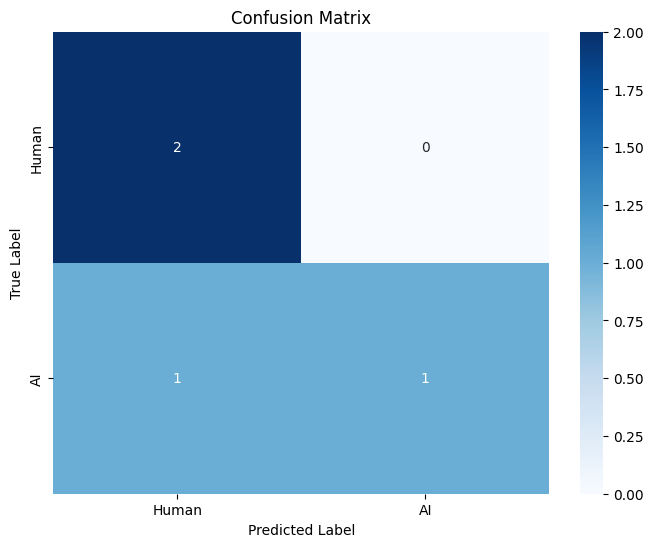


Top 15 Most Important Features:
 1. word_count                      -0.9663 (Human)
 2. ai_phrases_count                 0.2994 (AI)
 3. avg_word_length                  0.2713 (AI)
 4. question_count                  -0.2208 (Human)
 5. char_count                       0.2181 (AI)
 6. comma_count                      0.1786 (AI)
 7. factors                          0.1624 (AI)
 8. sentence_count                  -0.1404 (Human)
 9. entire                          -0.0991 (Human)
10. thinking                        -0.0831 (Human)
11. just                            -0.0749 (Human)
12. period_count                     0.0700 (AI)
13. coffee                          -0.0617 (Human)
14. consider                         0.0386 (AI)
15. like                            -0.0386 (Human)

TESTING WITH NEW EXAMPLES:

Example 1: 'tbh i think pineapple on pizza is actually pretty good but d...'
Prediction: Human (confidence: 0.996)
Probabilities - Human: 0.996, AI: 0.004

Example 2: 'I believe i

KeyboardInterrupt: Interrupted by user

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

# Handle newer NLTK versions that require punkt_tab
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    try:
        nltk.download('punkt_tab')
    except:
        pass  # Fall back to basic tokenization if punkt_tab fails

class AIHumanDetector:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 3),
            stop_words='english',
            lowercase=True,
            min_df=2,
            max_df=0.95
        )
        self.model = LogisticRegression(random_state=42, max_iter=1000)
        self.pipeline = None
        self.feature_names = None

    def extract_linguistic_features(self, text):
        """Extract linguistic features that may distinguish AI from human text"""
        features = {}

        # Basic text statistics
        features['char_count'] = len(text)
        features['word_count'] = len(text.split())

        # Safe sentence tokenization with fallback
        try:
            features['sentence_count'] = len(sent_tokenize(text))
        except:
            # Fallback: count periods, exclamations, and questions as sentence endings
            sentence_endings = text.count('.') + text.count('!') + text.count('?')
            features['sentence_count'] = max(sentence_endings, 1)

        features['avg_word_length'] = np.mean([len(word) for word in text.split()]) if text.split() else 0
        features['avg_sentence_length'] = features['word_count'] / max(features['sentence_count'], 1)

        # Punctuation and formatting
        features['exclamation_count'] = text.count('!')
        features['question_count'] = text.count('?')
        features['comma_count'] = text.count(',')
        features['period_count'] = text.count('.')
        features['uppercase_ratio'] = sum(1 for c in text if c.isupper()) / max(len(text), 1)

        # Vocabulary diversity
        words = text.lower().split()
        unique_words = set(words)
        features['vocabulary_diversity'] = len(unique_words) / max(len(words), 1)

        # Common AI patterns
        ai_phrases = ['as an ai', 'i apologize', 'i understand', 'furthermore', 'moreover',
                     'additionally', 'in conclusion', 'to summarize', 'it is important to note']
        features['ai_phrases_count'] = sum(phrase in text.lower() for phrase in ai_phrases)

        # Repetition patterns
        bigrams = [' '.join(words[i:i+2]) for i in range(len(words)-1)]
        if bigrams:
            bigram_counts = pd.Series(bigrams).value_counts()
            features['max_bigram_freq'] = bigram_counts.iloc[0] / len(bigrams) if len(bigrams) > 0 else 0
        else:
            features['max_bigram_freq'] = 0

        return features

    def preprocess_text(self, text):
        """Clean and preprocess text"""
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        # Remove special characters but keep punctuation
        text = re.sub(r'[^\w\s.,!?;:]', ' ', text)
        return text.strip()

    def prepare_features(self, texts):
        """Combine TF-IDF features with linguistic features"""
        # Extract linguistic features
        ling_features = []
        for text in texts:
            features = self.extract_linguistic_features(text)
            ling_features.append(features)

        ling_df = pd.DataFrame(ling_features)

        # Get TF-IDF features
        tfidf_features = self.vectorizer.fit_transform(texts) if not hasattr(self.vectorizer, 'vocabulary_') else self.vectorizer.transform(texts)

        # Combine features
        combined_features = np.hstack([tfidf_features.toarray(), ling_df.values])

        return combined_features

    def train(self, texts, labels):
        """Train the AI detection model"""
        print("Preprocessing texts...")
        processed_texts = [self.preprocess_text(text) for text in texts]

        print("Extracting features...")
        X = self.prepare_features(processed_texts)
        y = np.array(labels)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print("Training model...")
        self.model.fit(X_train, y_train)

        # Evaluate
        y_pred = self.model.predict(X_test)

        print("\nModel Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Human', 'AI']))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        return X_test, y_test, y_pred

    def predict(self, text):
        """Predict if text is AI or human generated"""
        processed_text = self.preprocess_text(text)
        features = self.prepare_features([processed_text])
        prediction = self.model.predict(features)[0]
        probability = self.model.predict_proba(features)[0]

        return {
            'prediction': 'AI' if prediction == 1 else 'Human',
            'confidence': max(probability),
            'probabilities': {
                'Human': probability[0],
                'AI': probability[1]
            }
        }

    def get_feature_importance(self, top_n=20):
        """Get most important features for classification"""
        if hasattr(self.model, 'coef_'):
            # Get TF-IDF feature names
            tfidf_names = self.vectorizer.get_feature_names_out()

            # Linguistic feature names
            ling_names = ['char_count', 'word_count', 'sentence_count', 'avg_word_length',
                         'avg_sentence_length', 'exclamation_count', 'question_count',
                         'comma_count', 'period_count', 'uppercase_ratio', 'vocabulary_diversity',
                         'ai_phrases_count', 'max_bigram_freq']

            all_names = list(tfidf_names) + ling_names

            importances = self.model.coef_[0]
            feature_importance = list(zip(all_names, importances))

            # Sort by absolute importance
            feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

            print(f"\nTop {top_n} Most Important Features:")
            for i, (feature, importance) in enumerate(feature_importance[:top_n]):
                direction = "AI" if importance > 0 else "Human"
                print(f"{i+1:2d}. {feature:30s} {importance:8.4f} ({direction})")

            return feature_importance[:top_n]

# Dataset loading functions
def load_dataset_from_csv(file_path):
    """Load dataset from CSV file with 'text' and 'label' columns"""
    try:
        df = pd.read_csv(file_path)

        # Validate required columns
        if 'text' not in df.columns or 'label' not in df.columns:
            raise ValueError("CSV must contain 'text' and 'label' columns")

        # Remove rows with missing values
        df = df.dropna(subset=['text', 'label'])

        # Convert labels to binary (0 for human, 1 for AI)
        # Assumes labels are either 0/1 or 'human'/'ai' or 'Human'/'AI'
        if df['label'].dtype == 'object':
            label_map = {
                'human': 0, 'Human': 0, 'HUMAN': 0,
                'ai': 1, 'AI': 1, 'artificial': 1, 'Artificial': 1
            }
            df['label'] = df['label'].map(label_map)

            # Check if mapping was successful
            if df['label'].isna().any():
                unique_labels = df['label'].unique()
                print(f"Warning: Unknown label values found: {unique_labels}")
                print("Please ensure labels are: 0/1 or human/ai")
                return None, None

        texts = df['text'].tolist()
        labels = df['label'].tolist()

        print(f"Dataset loaded successfully:")
        print(f"- Total samples: {len(texts)}")
        print(f"- Human samples: {sum(1 for label in labels if label == 0)}")
        print(f"- AI samples: {sum(1 for label in labels if label == 1)}")
        print(f"- Average text length: {np.mean([len(text) for text in texts]):.1f} characters")

        return texts, labels

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None, None
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None, None

def create_sample_dataset():
    """Create a sample dataset for demonstration (fallback when no CSV provided)"""

    # Sample human texts (you would replace this with real human-written content)
    human_texts = [
        "honestly i dont know why people get so worked up about this stuff. like yeah its important but theres gotta be better ways to handle it ya know?",
        "My cat knocked over my coffee this morning and I just sat there staring at the mess thinking about how this perfectly summarizes my entire week lol",
        "Been thinking lately... maybe we're all just winging it and pretending we know what we're doing. Kinda comforting in a weird way?",
        "Update: still can't figure out how to fold a fitted sheet. Beginning to suspect it's actually impossible and everyone's just lying about it",
        "You ever have those days where you feel like you're living in a sitcom but it's not the funny kind? Yeah, that's today.",
        "Pizza for breakfast? Judge me all you want but I'm living my best life over here",
        "Why do they call it rush hour when nobody's moving? English is weird man",
        "So apparently I've been pronouncing salmon wrong my entire life. How do you even recover from something like that??",
        "My plants are thriving which means I'm basically a responsible adult now right? Right?",
        "Coffee shop ran out of oat milk today and I had to reevaluate all my life choices in that moment"
    ]

    # Sample AI texts (mimicking typical AI writing patterns)
    ai_texts = [
        "I understand your concern about this matter. It is important to note that there are several approaches we could consider to address this issue effectively.",
        "Furthermore, I would like to emphasize that the implementation of such strategies requires careful consideration of multiple factors and stakeholder perspectives.",
        "As an AI assistant, I can provide you with comprehensive information regarding this topic. Additionally, it would be beneficial to explore various alternative solutions.",
        "To summarize, the key points we have discussed include several important considerations that warrant further analysis and evaluation.",
        "Moreover, it is crucial to recognize that this approach offers numerous advantages while simultaneously addressing potential concerns that may arise.",
        "In conclusion, I believe that a thorough examination of these factors will lead to more informed decision-making processes.",
        "I apologize for any confusion. Let me clarify the main aspects of this issue to ensure we have a comprehensive understanding.",
        "It is worth noting that the integration of these methodologies can significantly enhance the overall effectiveness of the proposed solution.",
        "Additionally, we should consider the long-term implications of implementing such measures within the broader context of organizational objectives.",
        "Therefore, I recommend conducting a detailed assessment to evaluate the feasibility and potential impact of these recommendations."
    ]

    # Create dataset
    texts = human_texts + ai_texts
    labels = [0] * len(human_texts) + [1] * len(ai_texts)  # 0 for human, 1 for AI

    return texts, labels

# Demo execution
if __name__ == "__main__":
    print("AI vs Human Text Detection Model")
    print("=" * 40)

    # Load dataset from CSV
    csv_file_path = "/kaggle/input/llm-detect-ai-generated-text-dataset/Training_Essay_Data.csv"
    if csv_file_path:
        texts, labels = load_dataset_from_csv(csv_file_path)
        if texts is None:
            print("Failed to load CSV. Using sample dataset instead.")
            texts, labels = create_sample_dataset()
    else:
        print("Using sample dataset for demonstration.")
        texts, labels = create_sample_dataset()

    # Check if we have enough data
    if len(texts) < 10:
        print("Warning: Dataset is very small. Consider using more samples for better performance.")

    # Check class balance
    human_count = sum(1 for label in labels if label == 0)
    ai_count = sum(1 for label in labels if label == 1)

    if human_count == 0 or ai_count == 0:
        print("Error: Dataset must contain both human and AI samples.")
        exit()

    balance_ratio = min(human_count, ai_count) / max(human_count, ai_count)
    if balance_ratio < 0.3:
        print(f"Warning: Dataset is imbalanced (ratio: {balance_ratio:.2f}). Consider balancing your classes.")

    # Initialize and train model
    detector = AIHumanDetector()
    X_test, y_test, y_pred = detector.train(texts, labels)

    # Show feature importance
    detector.get_feature_importance(15)

    # Test with new examples
    print("\n" + "="*50)
    print("TESTING WITH NEW EXAMPLES:")
    print("="*50)

    test_examples = [
        "tbh i think pineapple on pizza is actually pretty good but dont @ me about it",
        "I believe it would be beneficial to conduct a comprehensive analysis of this situation to ensure optimal outcomes.",
        "why is it called a building when its already built??? shower thoughts hitting different today",
        "Furthermore, the implementation of these methodologies requires careful consideration of various stakeholder perspectives and potential implications."
    ]

    for i, text in enumerate(test_examples, 1):
        result = detector.predict(text)
        print(f"\nExample {i}: '{text[:60]}{'...' if len(text) > 60 else ''}'")
        print(f"Prediction: {result['prediction']} (confidence: {result['confidence']:.3f})")
        print(f"Probabilities - Human: {result['probabilities']['Human']:.3f}, AI: {result['probabilities']['AI']:.3f}")

    print("\n" + "="*50)
    print("USAGE INSTRUCTIONS:")
    print("="*50)
    print("""
CSV File Format:
- Required columns: 'text' and either 'generator' or 'label'
- Labels should be: 0/1 or 'human'/'ai' (case insensitive)
- Example CSV structure:
  text,generator
  "This is human written text",human
  "I believe this demonstrates...",ai

To use with your own CSV:
    texts, labels = load_dataset_from_csv('your_dataset.csv')
    detector = AIHumanDetector()
    detector.train(texts, labels)
    result = detector.predict("Your text here")

Tips for better performance:
- Use thousands of samples for training
- Ensure balanced classes (similar number of human/AI samples)
- Include diverse text types and AI models in your dataset
    """)

    # Interactive prediction loop
    print("\n" + "="*50)
    print("INTERACTIVE PREDICTION MODE:")
    print("Enter text to classify (type 'quit' to exit):")
    print("="*50)

    while True:
        user_text = input("\nEnter text: ").strip()
        if user_text.lower() in ['quit', 'exit', 'q']:
            break
        if user_text:
            result = detector.predict(user_text)
            print(f"Prediction: {result['prediction']} (confidence: {result['confidence']:.3f})")
            print(f"Human: {result['probabilities']['Human']:.3f} | AI: {result['probabilities']['AI']:.3f}")

    print("Thanks for using the AI Detection Model!")

AI vs Human Text Detection Model (Fixed Version)
CSV columns: ['Text', 'Label']
Using text column: 'Text' and label column: 'Label'
Samples after removing NaN: 2504
Unique labels in dataset: {0, 1}
Dataset loaded successfully:
- Total samples: 2504
- Human samples: 1600
- AI samples: 904
- Average text length: 882.7 characters
Preprocessing texts...
Unique labels found: [0 1]
Training set size: 2003
Test set size: 501
Training labels distribution: [1280  723]
Test labels distribution: [320 181]
Extracting features from training data...
Extracting features from test data...
Feature matrix shape: (2003, 10015)
Training model...

Model Performance:
Accuracy: 0.9481

Classification Report:
              precision    recall  f1-score   support

       Human       0.92      1.00      0.96       320
          AI       1.00      0.86      0.92       181

    accuracy                           0.95       501
   macro avg       0.96      0.93      0.94       501
weighted avg       0.95      0.95

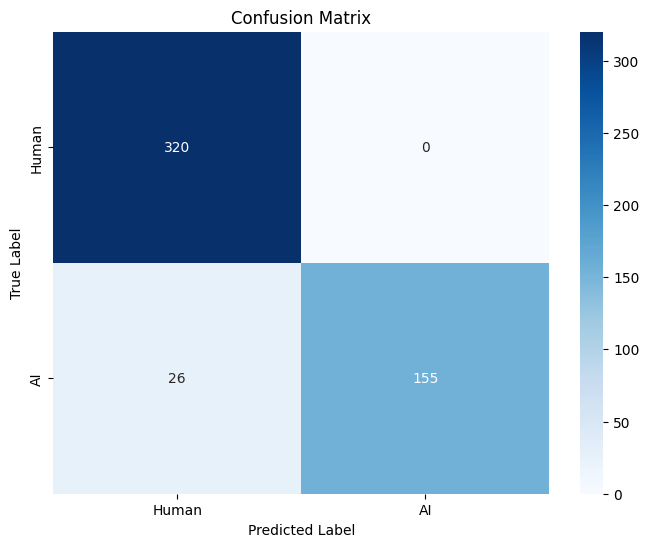


Diagnostic Information:
Predictions distribution: Human=346, AI=155
Confidence stats - Mean: 0.884, Std: 0.090

Sample predictions:
Text: Focusing on the application of AI in healthcare diagnostics, this research explores how machine lear...
True: AI, Predicted: AI, Confidence: 0.974
--------------------------------------------------
Text: | AI is utilized to predict the cycle time and output of tracked hydraulic excavators, addressing th...
True: AI, Predicted: AI, Confidence: 0.743
--------------------------------------------------
Text: An approach to hybrid artificial intelligence problem solving is presented in which the aim is to fo...
True: Human, Predicted: Human, Confidence: 0.952
--------------------------------------------------
Text: In this article, principles of architectures relating to normative agents are evaluated with regard ...
True: Human, Predicted: Human, Confidence: 0.856
--------------------------------------------------
Text: Forming processes are manufacturi

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

# Handle newer NLTK versions that require punkt_tab
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    try:
        nltk.download('punkt_tab')
    except:
        pass

class AIHumanDetector:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 3),
            stop_words='english',
            lowercase=True,
            min_df=2,
            max_df=0.95
        )
        self.scaler = StandardScaler()
        self.model = LogisticRegression(random_state=42, max_iter=1000)
        self.is_trained = False

    def extract_linguistic_features(self, text):
        """Extract linguistic features that may distinguish AI from human text"""
        features = {}

        # Basic text statistics
        features['char_count'] = len(text)
        features['word_count'] = len(text.split())

        # Safe sentence tokenization with fallback
        try:
            features['sentence_count'] = len(sent_tokenize(text))
        except:
            sentence_endings = text.count('.') + text.count('!') + text.count('?')
            features['sentence_count'] = max(sentence_endings, 1)

        words = text.split()
        features['avg_word_length'] = np.mean([len(word) for word in words]) if words else 0
        features['avg_sentence_length'] = features['word_count'] / max(features['sentence_count'], 1)

        # Punctuation and formatting
        features['exclamation_count'] = text.count('!')
        features['question_count'] = text.count('?')
        features['comma_count'] = text.count(',')
        features['period_count'] = text.count('.')
        features['uppercase_ratio'] = sum(1 for c in text if c.isupper()) / max(len(text), 1)

        # Vocabulary diversity
        words_lower = text.lower().split()
        unique_words = set(words_lower)
        features['vocabulary_diversity'] = len(unique_words) / max(len(words_lower), 1)

        # Common AI patterns
        ai_phrases = ['as an ai', 'i apologize', 'i understand', 'furthermore', 'moreover',
                     'additionally', 'in conclusion', 'to summarize', 'it is important to note',
                     'however', 'therefore', 'nevertheless']
        features['ai_phrases_count'] = sum(phrase in text.lower() for phrase in ai_phrases)

        # Repetition patterns
        if len(words_lower) > 1:
            bigrams = [' '.join(words_lower[i:i+2]) for i in range(len(words_lower)-1)]
            if bigrams:
                bigram_counts = pd.Series(bigrams).value_counts()
                features['max_bigram_freq'] = bigram_counts.iloc[0] / len(bigrams)
            else:
                features['max_bigram_freq'] = 0
        else:
            features['max_bigram_freq'] = 0

        # Text complexity
        features['syllable_density'] = self._estimate_syllables(text) / max(features['word_count'], 1)
        features['long_word_ratio'] = sum(1 for word in words if len(word) > 6) / max(len(words), 1)

        return features

    def _estimate_syllables(self, text):
        """Rough syllable count estimation"""
        words = re.findall(r'\b\w+\b', text.lower())
        total_syllables = 0
        for word in words:
            syllables = max(1, len(re.findall(r'[aeiouy]+', word)))
            total_syllables += syllables
        return total_syllables

    def preprocess_text(self, text):
        """Clean and preprocess text"""
        if not isinstance(text, str):
            text = str(text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        # Remove special characters but keep punctuation
        text = re.sub(r'[^\w\s.,!?;:]', ' ', text)
        return text.strip()

    def prepare_features(self, texts, fit_vectorizer=False, fit_scaler=False):
        """Combine TF-IDF features with linguistic features"""
        # Preprocess texts
        processed_texts = [self.preprocess_text(text) for text in texts]

        # Extract linguistic features
        ling_features = []
        for text in processed_texts:
            features = self.extract_linguistic_features(text)
            ling_features.append(features)

        ling_df = pd.DataFrame(ling_features)

        # Get TF-IDF features
        if fit_vectorizer:
            tfidf_features = self.vectorizer.fit_transform(processed_texts)
        else:
            tfidf_features = self.vectorizer.transform(processed_texts)

        # Scale linguistic features
        if fit_scaler:
            ling_scaled = self.scaler.fit_transform(ling_df.values)
        else:
            ling_scaled = self.scaler.transform(ling_df.values)

        # Combine features
        combined_features = np.hstack([tfidf_features.toarray(), ling_scaled])

        return combined_features

    def train(self, texts, labels):
        """Train the AI detection model"""
        print("Preprocessing texts...")

        # Convert labels to ensure they're binary
        labels = np.array(labels)
        unique_labels = np.unique(labels)
        print(f"Unique labels found: {unique_labels}")

        # Split data BEFORE any feature extraction
        X_texts_train, X_texts_test, y_train, y_test = train_test_split(
            texts, labels, test_size=0.2, random_state=42, stratify=labels
        )

        print(f"Training set size: {len(X_texts_train)}")
        print(f"Test set size: {len(X_texts_test)}")
        print(f"Training labels distribution: {np.bincount(y_train)}")
        print(f"Test labels distribution: {np.bincount(y_test)}")

        print("Extracting features from training data...")
        # Fit vectorizer and scaler ONLY on training data
        X_train = self.prepare_features(X_texts_train, fit_vectorizer=True, fit_scaler=True)

        print("Extracting features from test data...")
        # Transform test data using fitted vectorizer and scaler
        X_test = self.prepare_features(X_texts_test, fit_vectorizer=False, fit_scaler=False)

        print(f"Feature matrix shape: {X_train.shape}")

        print("Training model...")
        self.model.fit(X_train, y_train)

        # Evaluate on test set
        y_pred = self.model.predict(X_test)
        y_pred_proba = self.model.predict_proba(X_test)

        self.is_trained = True

        print("\nModel Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Human', 'AI']))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Check for potential issues
        self._diagnose_predictions(X_texts_test, y_test, y_pred, y_pred_proba)

        return X_test, y_test, y_pred

    def _diagnose_predictions(self, texts, y_true, y_pred, y_pred_proba):
        """Diagnose potential issues with predictions"""
        print("\nDiagnostic Information:")

        # Check prediction distribution
        pred_counts = np.bincount(y_pred)
        print(f"Predictions distribution: Human={pred_counts[0]}, AI={pred_counts[1] if len(pred_counts) > 1 else 0}")

        # Check confidence distribution
        max_proba = np.max(y_pred_proba, axis=1)
        print(f"Confidence stats - Mean: {np.mean(max_proba):.3f}, Std: {np.std(max_proba):.3f}")

        # Show some examples
        print("\nSample predictions:")
        for i in range(min(5, len(texts))):
            text_preview = texts[i][:100] + "..." if len(texts[i]) > 100 else texts[i]
            true_label = "Human" if y_true[i] == 0 else "AI"
            pred_label = "Human" if y_pred[i] == 0 else "AI"
            confidence = max_proba[i]

            print(f"Text: {text_preview}")
            print(f"True: {true_label}, Predicted: {pred_label}, Confidence: {confidence:.3f}")
            print("-" * 50)

    def predict(self, text):
        """Predict if text is AI or human generated"""
        if not self.is_trained:
            raise ValueError("Model must be trained before making predictions")

        features = self.prepare_features([text], fit_vectorizer=False, fit_scaler=False)
        prediction = self.model.predict(features)[0]
        probability = self.model.predict_proba(features)[0]

        return {
            'prediction': 'AI' if prediction == 1 else 'Human',
            'confidence': max(probability),
            'probabilities': {
                'Human': probability[0],
                'AI': probability[1]
            }
        }

    def save_model(self, filepath):
        """Save the trained model"""
        if not self.is_trained:
            raise ValueError("Model must be trained before saving")

        model_data = {
            'vectorizer': self.vectorizer,
            'scaler': self.scaler,
            'model': self.model,
            'is_trained': self.is_trained
        }

        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """Load a trained model"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)

        self.vectorizer = model_data['vectorizer']
        self.scaler = model_data['scaler']
        self.model = model_data['model']
        self.is_trained = model_data['is_trained']
        print(f"Model loaded from {filepath}")

    def get_feature_importance(self, top_n=20):
        """Get most important features for classification"""
        if not self.is_trained:
            raise ValueError("Model must be trained before getting feature importance")

        if hasattr(self.model, 'coef_'):
            # Get TF-IDF feature names
            tfidf_names = self.vectorizer.get_feature_names_out()

            # Linguistic feature names
            ling_names = ['char_count', 'word_count', 'sentence_count', 'avg_word_length',
                         'avg_sentence_length', 'exclamation_count', 'question_count',
                         'comma_count', 'period_count', 'uppercase_ratio', 'vocabulary_diversity',
                         'ai_phrases_count', 'max_bigram_freq', 'syllable_density', 'long_word_ratio']

            all_names = list(tfidf_names) + ling_names

            importances = self.model.coef_[0]
            feature_importance = list(zip(all_names, importances))

            # Sort by absolute importance
            feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

            print(f"\nTop {top_n} Most Important Features:")
            for i, (feature, importance) in enumerate(feature_importance[:top_n]):
                direction = "AI" if importance > 0 else "Human"
                print(f"{i+1:2d}. {feature:30s} {importance:8.4f} ({direction})")

            return feature_importance[:top_n]

def load_dataset_from_csv(file_path):
    """Load dataset from CSV file with 'text' and 'generator' columns"""
    try:
        df = pd.read_csv(file_path)
        print(f"CSV columns: {df.columns.tolist()}")

        # Check for required columns
        text_col = None
        label_col = None

        # Find text column
        for col in ['text', 'Text', 'content', 'Content']:
            if col in df.columns:
                text_col = col
                break

        # Find label column
        for col in ['generator', 'label', 'Label', 'class', 'Class','generated']:
            if col in df.columns:
                label_col = col
                break

        if text_col is None:
            raise ValueError("No text column found. Expected: 'text', 'Text', 'content', or 'Content'")
        if label_col is None:
            raise ValueError("No label column found. Expected: 'generator', 'label', 'Label', 'class', or 'Class'")

        print(f"Using text column: '{text_col}' and label column: '{label_col}'")

        # Remove rows with missing values
        df = df.dropna(subset=[text_col, label_col])
        print(f"Samples after removing NaN: {len(df)}")

        texts = df[text_col].tolist()
        labels = df[label_col].tolist()

        # Convert labels to binary (0 for human, 1 for AI)
        unique_labels = set(labels)
        print(f"Unique labels in dataset: {unique_labels}")

        # Handle different label formats
        processed_labels = []
        for label in labels:
            if label in [0, '0', 'human', 'Human', 'HUMAN']:
                processed_labels.append(0)
            elif label in [1, '1', 'ai', 'AI', 'artificial', 'Artificial']:
                processed_labels.append(1)
            else:
                print(f"Warning: Unknown label '{label}', skipping...")
                continue

        # Filter texts to match processed labels
        if len(processed_labels) != len(texts):
            print("Filtering texts to match valid labels...")
            valid_texts = []
            processed_labels_final = []
            for text, label in zip(texts, labels):
                if label in [0, '0', 'human', 'Human', 'HUMAN', 1, '1', 'ai', 'AI', 'artificial', 'Artificial']:
                    valid_texts.append(text)
                    if label in [0, '0', 'human', 'Human', 'HUMAN']:
                        processed_labels_final.append(0)
                    else:
                        processed_labels_final.append(1)
            texts = valid_texts
            processed_labels = processed_labels_final

        print(f"Dataset loaded successfully:")
        print(f"- Total samples: {len(texts)}")
        print(f"- Human samples: {sum(1 for label in processed_labels if label == 0)}")
        print(f"- AI samples: {sum(1 for label in processed_labels if label == 1)}")
        print(f"- Average text length: {np.mean([len(str(text)) for text in texts]):.1f} characters")

        return texts, processed_labels

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None, None
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None, None

# Demo execution
if __name__ == "__main__":
    print("AI vs Human Text Detection Model (Fixed Version)")
    print("=" * 50)

    # Load your dataset
    csv_file_path = "/content/combined_dataset.csv"

    if csv_file_path and csv_file_path != "":
        texts, labels = load_dataset_from_csv(csv_file_path)
        if texts is None:
            print("Failed to load CSV. Please check the file path and format.")
            exit()
    else:
        print("No CSV path provided. Please provide a valid CSV file path.")
        exit()

    # Check if we have enough data
    if len(texts) < 20:
        print("Warning: Dataset is very small. Consider using more samples for better performance.")

    # Check class balance
    human_count = sum(1 for label in labels if label == 0)
    ai_count = sum(1 for label in labels if label == 1)

    if human_count == 0 or ai_count == 0:
        print("Error: Dataset must contain both human and AI samples.")
        exit()

    balance_ratio = min(human_count, ai_count) / max(human_count, ai_count)
    if balance_ratio < 0.3:
        print(f"Warning: Dataset is imbalanced (ratio: {balance_ratio:.2f}). Consider balancing your classes.")

    # Initialize and train model
    detector = AIHumanDetector()
    X_test, y_test, y_pred = detector.train(texts, labels)

    # Show feature importance
    detector.get_feature_importance(15)

    # Interactive prediction loop
    print("\n" + "="*50)
    print("INTERACTIVE PREDICTION MODE:")
    print("Enter text to classify (type 'quit' to exit):")
    print("="*50)

    while True:
        user_text = input("\nEnter text: ").strip()
        if user_text.lower() in ['quit', 'exit', 'q']:
            break
        if user_text:
            try:
                result = detector.predict(user_text)
                print(f"Prediction: {result['prediction']} (confidence: {result['confidence']:.3f})")
                print(f"Human: {result['probabilities']['Human']:.3f} | AI: {result['probabilities']['AI']:.3f}")
            except Exception as e:
                print(f"Error during prediction: {str(e)}")

    # Option to save the model
    save_model = input("\nWould you like to save the trained model? (y/n): ").strip().lower()
    if save_model in ['y', 'yes']:
        model_path = input("Enter path to save model (e.g., 'ai_detector_model.pkl'): ").strip()
        if model_path:
            detector.save_model(model_path)

    print("Thanks for using the AI Detection Model!")